A notebook that obtains the average RGB color of each cluster (both cluster-wise an image-wise calculation). Also displays the furthest images from each cluster centroid. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

In [2]:
num_clusters = 6

In [ ]:
# Collect statistics from images in a cluster first, then collect statistics for the entire cluster
def analyze_cluster_image_first(cluster_path):
    image_rgb_stats = []
    image_lab_stats = []
    
    for image_file in os.listdir(cluster_path):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(cluster_path, image_file)
            img = cv2.imread(img_path)
            
            # Create mask for non-black pixels (RGB != 0,0,0)
            non_black_mask = ~np.all(img == [0, 0, 0], axis=2)
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pixels_rgb = img_rgb.reshape(-1, 3)
            non_black_mask_flat = non_black_mask.flatten()
            
            # Filter out black pixels
            img_rgb_filtered = pixels_rgb[non_black_mask_flat]
            if img_rgb_filtered.size == 0:
                continue  # Skip this image if all pixels are black
            
            # Convert RGB to LAB
            img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            pixels_lab = img_lab.reshape(-1, 3)
            img_lab_filtered = pixels_lab[non_black_mask_flat]
            
            # Calculate RGB and LAB statistics for this image
            img_rgb_stats = {
                'avg': np.mean(img_rgb_filtered, axis=0),
                'min': np.min(img_rgb_filtered, axis=0),
                'max': np.max(img_rgb_filtered, axis=0)
            }
            img_lab_stats = {
                'avg': np.mean(img_lab_filtered, axis=0),
                'min': np.min(img_lab_filtered, axis=0),
                'max': np.max(img_lab_filtered, axis=0)
            }
            
            image_rgb_stats.append(img_rgb_stats)
            image_lab_stats.append(img_lab_stats)
    
    if len(image_rgb_stats) == 0:
        return {
            'rgb': {'avg': [0, 0, 0], 'min': [0, 0, 0], 'max': [0, 0, 0]},
            'lab': {'avg': [0, 0, 0], 'min': [0, 0, 0], 'max': [0, 0, 0]}
        }
    
    # Step 2: Aggregate the image statistics to calculate cluster statistics
    avg_rgb_values = np.mean([img_stats['avg'] for img_stats in image_rgb_stats], axis=0)
    min_rgb_values = np.min([img_stats['min'] for img_stats in image_rgb_stats], axis=0)
    max_rgb_values = np.max([img_stats['max'] for img_stats in image_rgb_stats], axis=0)
    
    avg_lab_values = np.mean([img_stats['avg'] for img_stats in image_lab_stats], axis=0)
    min_lab_values = np.min([img_stats['min'] for img_stats in image_lab_stats], axis=0)
    max_lab_values = np.max([img_stats['max'] for img_stats in image_lab_stats], axis=0)
    
    return {
        'rgb': {
            'avg': avg_rgb_values,
            'min': min_rgb_values,
            'max': max_rgb_values
        },
        'lab': {
            'avg': avg_lab_values,
            'min': min_lab_values,
            'max': max_lab_values
        }
    }

In [4]:
# Collect average RGB/LAB values of all images in a cluster, then use those averages to calculate cluster statistics
def analyze_cluster_image_averages(cluster_path):
    image_rgb_avgs = []
    image_lab_avgs = []
    
    for image_file in os.listdir(cluster_path):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(cluster_path, image_file)
            img = cv2.imread(img_path)
            
            # Create mask for non-black pixels (RGB != 0,0,0)
            non_black_mask = ~np.all(img == [0, 0, 0], axis=2)
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pixels_rgb = img_rgb.reshape(-1, 3)
            non_black_mask_flat = non_black_mask.flatten()
            
            # Filter out black pixels
            img_rgb_filtered = pixels_rgb[non_black_mask_flat]
            if img_rgb_filtered.size == 0:
                continue
            
            # Convert RGB to LAB
            img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            pixels_lab = img_lab.reshape(-1, 3)
            img_lab_filtered = pixels_lab[non_black_mask_flat]
            
            # Calculate average RGB and LAB values for this image
            img_rgb_avg = np.mean(img_rgb_filtered, axis=0)
            img_lab_avg = np.mean(img_lab_filtered, axis=0)
            
            image_rgb_avgs.append(img_rgb_avg)
            image_lab_avgs.append(img_lab_avg)
    
    if len(image_rgb_avgs) == 0:
        return {
            'rgb': {'avg': [0, 0, 0], 'min': [0, 0, 0], 'max': [0, 0, 0]},
            'lab': {'avg': [0, 0, 0], 'min': [0, 0, 0], 'max': [0, 0, 0]}
        }
    
    # Convert lists to numpy arrays for easier calculations
    image_rgb_avgs = np.array(image_rgb_avgs)
    image_lab_avgs = np.array(image_lab_avgs)
    
    return {
        'rgb': {
            'avg': np.mean(image_rgb_avgs, axis=0),
            'min': np.min(image_rgb_avgs, axis=0),
            'max': np.max(image_rgb_avgs, axis=0)
        },
        'lab': {
            'avg': np.mean(image_lab_avgs, axis=0),
            'min': np.min(image_lab_avgs, axis=0),
            'max': np.max(image_lab_avgs, axis=0)
        }
    }

# Utility Functions

In [5]:
def collect_statistics(clusters_root_path, analysis_type='all_pixels'):
    clusters_stats = []
    for cluster_name in os.listdir(clusters_root_path):
        cluster_path = os.path.join(clusters_root_path, cluster_name)
        if os.path.isdir(cluster_path):
            print(f"Analyzing cluster: {cluster_name}")
            if analysis_type == 'all_pixels':
                stats = analyze_cluster_image_first(cluster_path)
            elif analysis_type == 'image_averages':
                stats = analyze_cluster_image_averages(cluster_path)
            else:
                raise ValueError("Invalid analysis_type.")
            
            stats_flat = {
                'cluster_name': cluster_name,
                'rgb_avg_r': stats['rgb']['avg'][0],
                'rgb_avg_g': stats['rgb']['avg'][1],
                'rgb_avg_b': stats['rgb']['avg'][2],
                'rgb_min_r': stats['rgb']['min'][0],
                'rgb_min_g': stats['rgb']['min'][1],
                'rgb_min_b': stats['rgb']['min'][2],
                'rgb_max_r': stats['rgb']['max'][0],
                'rgb_max_g': stats['rgb']['max'][1],
                'rgb_max_b': stats['rgb']['max'][2],
                'lab_avg_l': stats['lab']['avg'][0],
                'lab_avg_a': stats['lab']['avg'][1],
                'lab_avg_b': stats['lab']['avg'][2],
                'lab_min_l': stats['lab']['min'][0],
                'lab_min_a': stats['lab']['min'][1],
                'lab_min_b': stats['lab']['min'][2],
                'lab_max_l': stats['lab']['max'][0],
                'lab_max_a': stats['lab']['max'][1],
                'lab_max_b': stats['lab']['max'][2],
            }
            clusters_stats.append(stats_flat)
            
    df_stats = pd.DataFrame(clusters_stats)
    return df_stats

In [6]:
def save_statistics_to_csv(df_stats, csv_file_path):
    df_stats.to_csv(csv_file_path, index=False)
    
    
def visualize_cluster_stats(stats, cluster_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # RGB visualization
    rgb_data = np.array([stats['rgb']['min'], stats['rgb']['avg'], stats['rgb']['max']])
    print("RGB Data before normalization:", rgb_data)
    rgb_data_normalized = rgb_data / 255.0  # Normalize to [0, 1]
    rgb_data_normalized = np.clip(rgb_data_normalized, 0, 1)  # Ensure values are within [0,1]
    ax1.imshow(rgb_data_normalized.reshape(1, -1, 3))
    ax1.set_title(f'{cluster_name} - RGB Values')
    ax1.set_yticks([])
    ax1.set_xticks([0, 1, 2])
    ax1.set_xticklabels(['Min', 'Avg', 'Max'])
    
    # LAB visualization
    lab_data = np.array([stats['lab']['min'], stats['lab']['avg'], stats['lab']['max']])
    print("LAB Data before conversion:", lab_data)
    lab_data_clipped = np.clip(lab_data, 0, 255)
    lab_data_uint8 = lab_data_clipped.astype(np.uint8).reshape(1, -1, 3)
    lab_data_bgr = cv2.cvtColor(lab_data_uint8, cv2.COLOR_LAB2BGR)
    lab_data_rgb = cv2.cvtColor(lab_data_bgr, cv2.COLOR_BGR2RGB)
    lab_data_rgb_normalized = lab_data_rgb / 255.0  # Normalize to [0, 1]
    lab_data_rgb_normalized = np.clip(lab_data_rgb_normalized, 0, 1)
    ax2.imshow(lab_data_rgb_normalized)
    ax2.set_title(f'{cluster_name} - LAB Values')
    ax2.set_yticks([])
    ax2.set_xticks([0, 1, 2])
    ax2.set_xticklabels(['Min', 'Avg', 'Max'])
    
    plt.tight_layout()
    plt.show()


def visualize_clusters_average_colors(df_stats):
    # Number of clusters
    num_clusters = len(df_stats)
    
    # Get the average RGB values and cluster names
    avg_colors = df_stats[['rgb_avg_r', 'rgb_avg_g', 'rgb_avg_b']].values
    cluster_names = df_stats['cluster_name'].tolist()
    
    avg_colors_normalized = avg_colors / 255.0
    avg_colors_normalized = np.clip(avg_colors_normalized, 0, 1)
    
    cols = min(num_clusters, 5)
    rows = (num_clusters + cols - 1) // cols
    
    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    
    # Flatten axes array for easy iteration if it's 2D
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes] if num_clusters == 1 else axes
    
    for i in range(num_clusters):
        color_patch = np.ones((10, 10, 3)) * avg_colors_normalized[i].reshape(1, 1, 3)
        axes[i].imshow(color_patch)
        axes[i].axis('off')
        axes[i].set_title(cluster_names[i], fontsize=10)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Cluster Statistics (All Pixels)

Analyzing cluster: cluster_0
Analyzing cluster: cluster_1
Analyzing cluster: cluster_2
Analyzing cluster: cluster_3
Analyzing cluster: cluster_4
Analyzing cluster: cluster_5
Statistics have been saved to clusters_statistics_all_pixels_6.csv
RGB Data before normalization: [[  0.           0.           0.        ]
 [150.0535615  105.24935345  94.75703976]
 [255.         255.         255.        ]]
LAB Data before conversion: [[  0.         115.         116.        ]
 [122.91125675 144.42022413 141.11499796]
 [255.         183.         193.        ]]


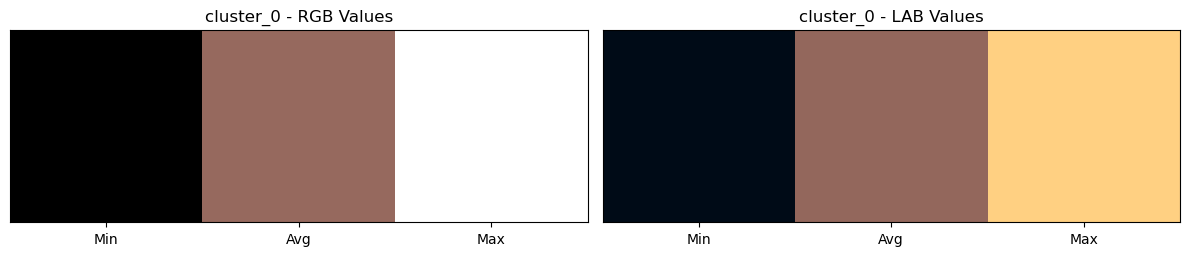

RGB Data before normalization: [[  0.           0.           0.        ]
 [141.49137031 123.96392162 130.08628364]
 [255.         255.         255.        ]]
LAB Data before conversion: [[  0.         110.          98.        ]
 [135.48128043 135.91172163 127.35626784]
 [255.         172.         162.        ]]


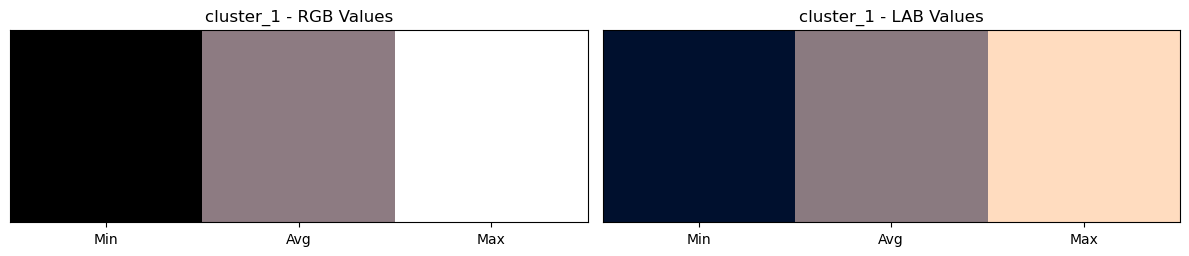

RGB Data before normalization: [[  0.           0.           0.        ]
 [167.14725347 106.85016779 107.88083461]
 [255.         255.         255.        ]]
LAB Data before conversion: [[  0.         113.         108.        ]
 [130.12987156 151.95739975 137.78369518]
 [255.         194.         183.        ]]


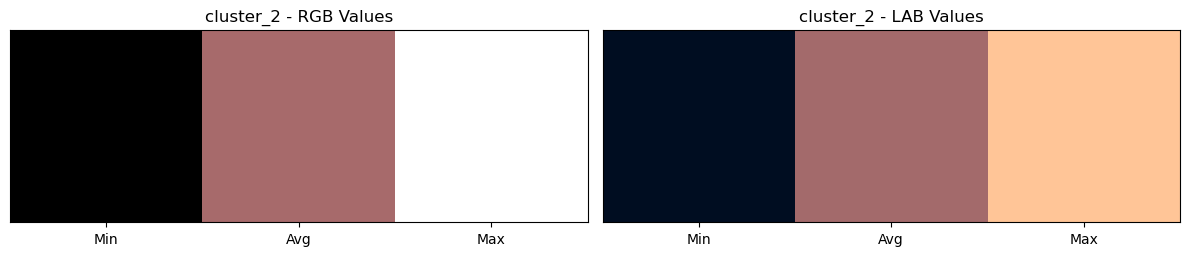

RGB Data before normalization: [[  0.           0.           0.        ]
 [151.32965425 118.83617565 119.7181272 ]
 [255.         255.         255.        ]]
LAB Data before conversion: [[  0.         115.         101.        ]
 [133.80421829 140.82788491 132.51612591]
 [255.         185.         186.        ]]


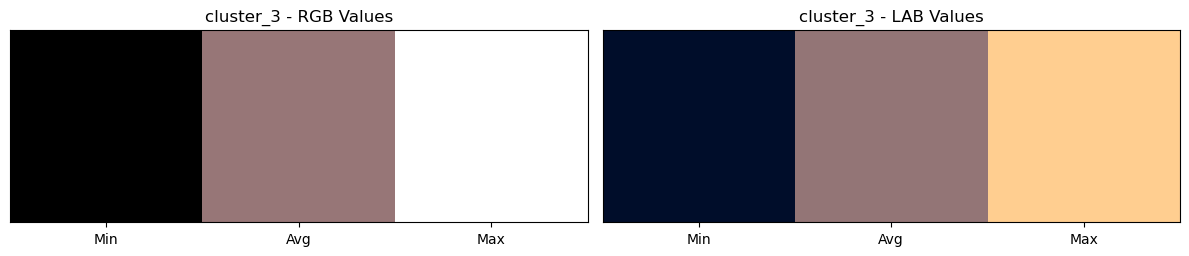

RGB Data before normalization: [[  0.           0.           0.        ]
 [156.52225777 110.83924714 115.59453917]
 [255.         255.         255.        ]]
LAB Data before conversion: [[  0.         113.         101.        ]
 [129.86141244 146.65928699 132.82498803]
 [255.         185.         193.        ]]


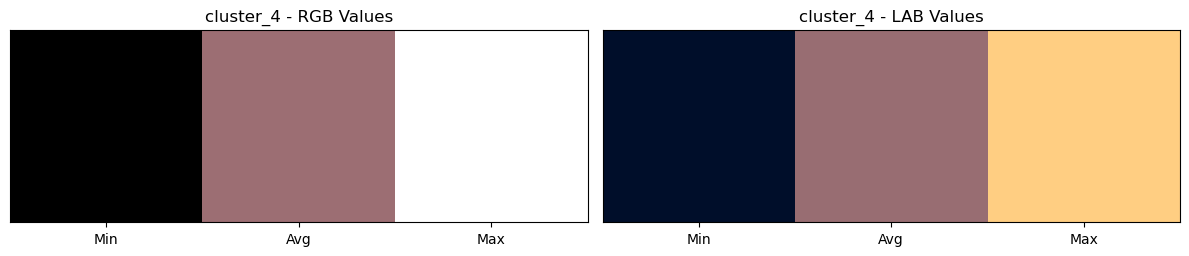

RGB Data before normalization: [[  0.           0.           0.        ]
 [204.01073431 114.99959784  76.90783402]
 [255.         255.         255.        ]]
LAB Data before conversion: [[  0.         114.         109.        ]
 [146.66607892 159.21495307 163.67457104]
 [255.         199.         200.        ]]


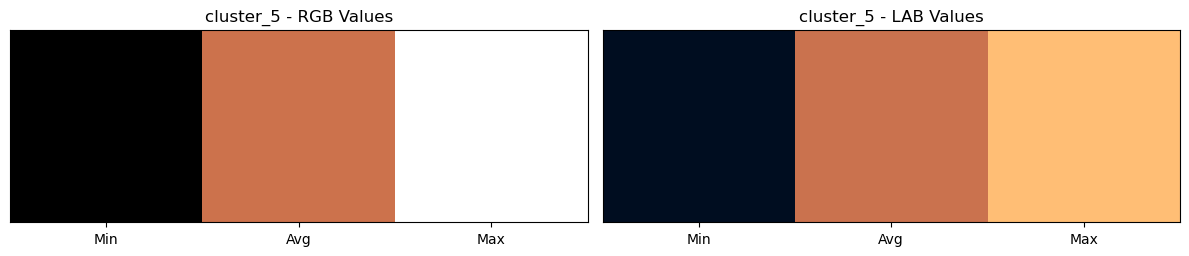

In [7]:
clusters_root_path = f"clusters/clustered_images"
all_pixels_csv_file_path = f'clusters_statistics_all_pixels_{num_clusters}.csv'

df_stats_all_pixels = collect_statistics(clusters_root_path)
save_statistics_to_csv(df_stats_all_pixels, all_pixels_csv_file_path)

print(f"Statistics have been saved to {all_pixels_csv_file_path}")

for index, row in df_stats_all_pixels.iterrows():
    stats = {
        'rgb': {
            'avg': np.array([row['rgb_avg_r'], row['rgb_avg_g'], row['rgb_avg_b']]),
            'min': np.array([row['rgb_min_r'], row['rgb_min_g'], row['rgb_min_b']]),
            'max': np.array([row['rgb_max_r'], row['rgb_max_g'], row['rgb_max_b']])
        },
        'lab': {
            'avg': np.array([row['lab_avg_l'], row['lab_avg_a'], row['lab_avg_b']]),
            'min': np.array([row['lab_min_l'], row['lab_min_a'], row['lab_min_b']]),
            'max': np.array([row['lab_max_l'], row['lab_max_a'], row['lab_max_b']])
        }
    }
    visualize_cluster_stats(stats, row['cluster_name'])

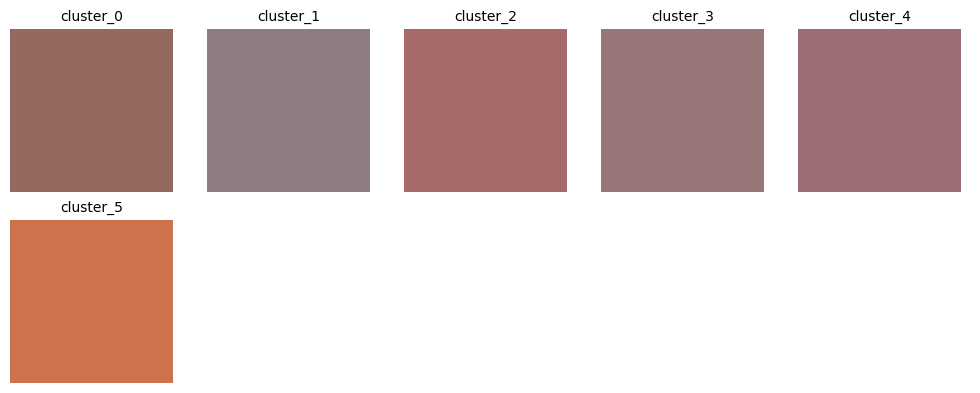

In [8]:
visualize_clusters_average_colors(df_stats_all_pixels)

# Cluster Statistics (Image Averages)

Analyzing cluster: cluster_0
Analyzing cluster: cluster_1
Analyzing cluster: cluster_2
Analyzing cluster: cluster_3
Analyzing cluster: cluster_4
Analyzing cluster: cluster_5
Statistics have been saved to clusters_statistics_image_averages_6.csv
RGB Data before normalization: [[ 90.14478853  53.9607452   44.25076729]
 [150.0535615  105.24935345  94.75703976]
 [220.52723817 159.46124015 145.34383866]]
LAB Data before conversion: [[ 67.63228163 138.62018495 135.42108822]
 [122.91125675 144.42022413 141.11499796]
 [179.05853794 148.62676684 157.76211713]]


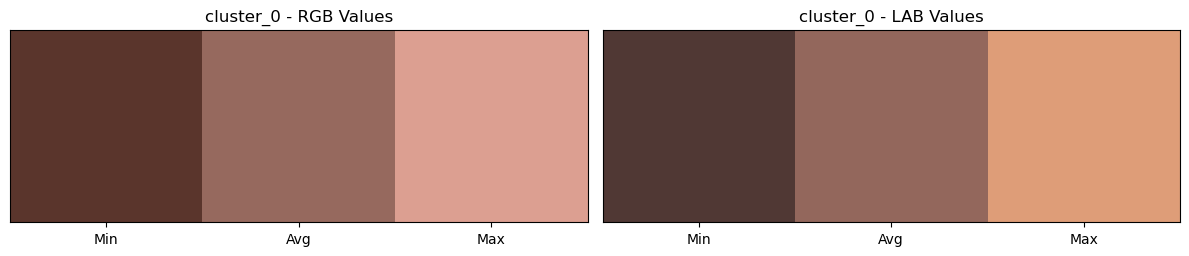

RGB Data before normalization: [[ 83.07280154  73.88897555  73.49411596]
 [141.49137031 123.96392162 130.08628364]
 [197.36710341 182.00953924 200.66975963]]
LAB Data before conversion: [[ 84.34135769 128.31693567 116.76097795]
 [135.48128043 135.91172163 127.35626784]
 [192.25985592 140.32377017 137.64395624]]


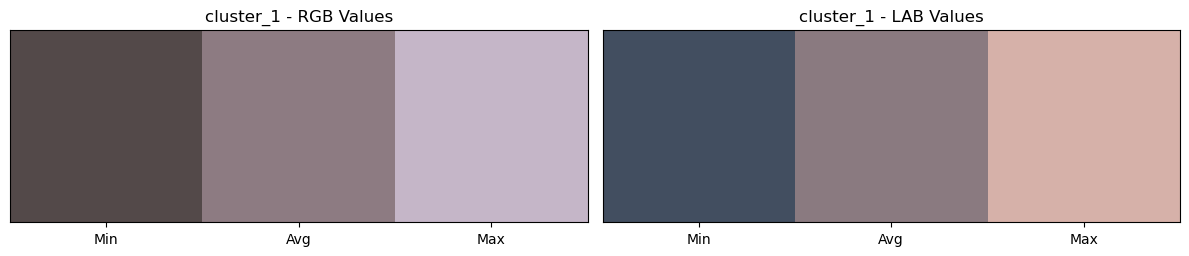

RGB Data before normalization: [[ 95.73608264  47.1178843   40.74418182]
 [167.14725347 106.85016779 107.88083461]
 [212.1872603  145.68618285 153.63911792]]
LAB Data before conversion: [[ 65.89581818 148.18545151 125.72076225]
 [130.12987156 151.95739975 137.78369518]
 [168.74978269 161.13316423 154.34173128]]


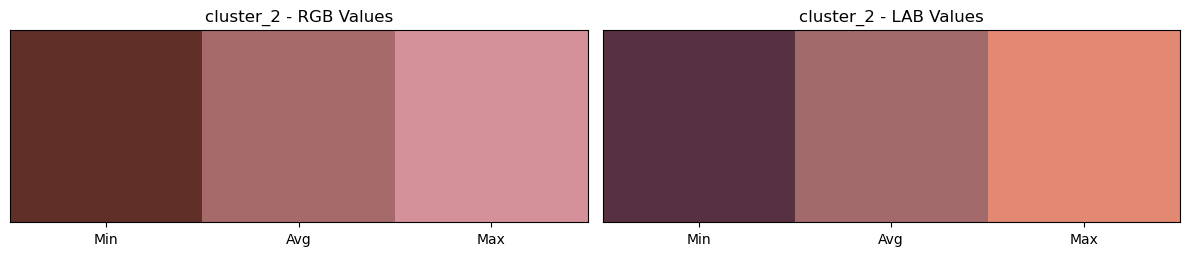

RGB Data before normalization: [[ 91.54611944  62.64404614  60.42838669]
 [151.32965425 118.83617565 119.7181272 ]
 [216.51338964 182.5385036  173.55146481]]
LAB Data before conversion: [[ 75.26781763 135.03722129 121.56622586]
 [133.80421829 140.82788491 132.51612591]
 [193.79060762 145.23507563 150.09876033]]


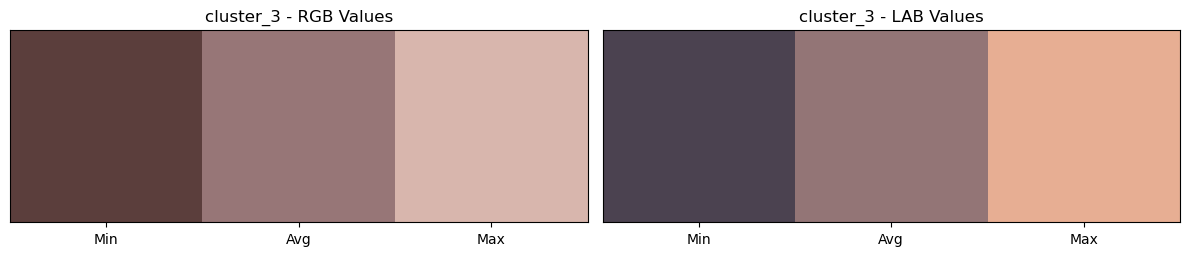

RGB Data before normalization: [[ 84.82206942  43.22431033  41.80828973]
 [156.52225777 110.83924714 115.59453917]
 [212.04182313 163.02549991 172.72929966]]
LAB Data before conversion: [[ 59.38374928 143.15235671 122.35588625]
 [129.86141244 146.65928699 132.82498803]
 [180.80723104 153.54298885 137.77941289]]


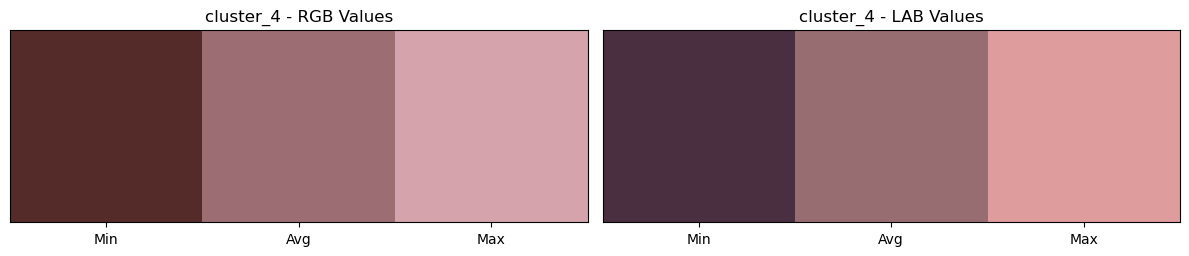

RGB Data before normalization: [[153.51099455  69.04745254  37.30210176]
 [204.01073431 114.99959784  76.90783402]
 [225.62580384 145.61660449 107.07788534]]
LAB Data before conversion: [[100.76240109 152.09429895 145.45078385]
 [146.66607892 159.21495307 163.67457104]
 [172.66252124 167.73983375 175.34555691]]


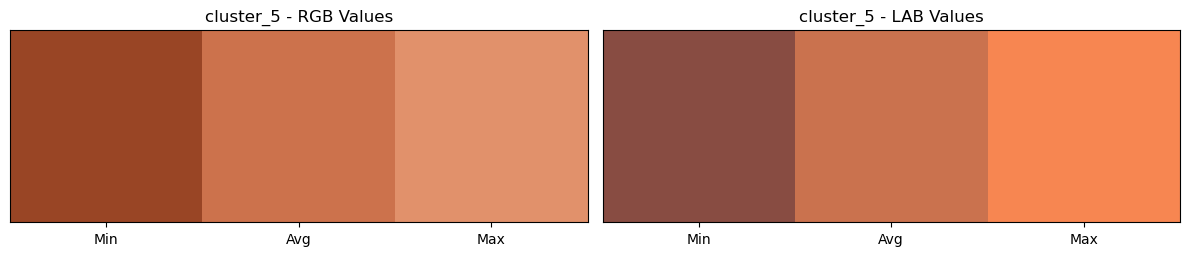

In [9]:
img_averages_csv_file_path = f'clusters_statistics_image_averages_{num_clusters}.csv'
df_stats_avgs = collect_statistics(clusters_root_path, 'image_averages')
save_statistics_to_csv(df_stats_avgs, img_averages_csv_file_path)

print(f"Statistics have been saved to {img_averages_csv_file_path}")

for index, row in df_stats_avgs.iterrows():
    stats = {
        'rgb': {
            'avg': np.array([row['rgb_avg_r'], row['rgb_avg_g'], row['rgb_avg_b']]),
            'min': np.array([row['rgb_min_r'], row['rgb_min_g'], row['rgb_min_b']]),
            'max': np.array([row['rgb_max_r'], row['rgb_max_g'], row['rgb_max_b']])
        },
        'lab': {
            'avg': np.array([row['lab_avg_l'], row['lab_avg_a'], row['lab_avg_b']]),
            'min': np.array([row['lab_min_l'], row['lab_min_a'], row['lab_min_b']]),
            'max': np.array([row['lab_max_l'], row['lab_max_a'], row['lab_max_b']])
        }
    }
    visualize_cluster_stats(stats, row['cluster_name'])

# Furthest Images from Cluster Centroids

In [10]:
# Using image averages
def calculate_distances_to_centroids(clusters_root_path):
    distances_data = []
    
    # For each cluster directory
    for cluster_dir in Path(clusters_root_path).glob('*'):
        cluster_name = cluster_dir.name
        
        # Calculate cluster centroid from existing statistics
        centroid = df_stats_avgs[df_stats_avgs['cluster_name'] == cluster_name][['lab_avg_l', 'lab_avg_a', 'lab_avg_b']].values[0]
        
        # Process each image in cluster
        for img_path in cluster_dir.glob('*.jpg'):
            # Read and process image
            img = cv2.imread(str(img_path))
            img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            
            # Calculate average LAB values for image
            img_avg_lab = np.mean(img_lab.reshape(-1, 3), axis=0)
            
            # Calculate Euclidean distance
            distance = np.linalg.norm(img_avg_lab - centroid)
            
            distances_data.append({
                'image_name': img_path.name,
                'cluster': cluster_name,
                'centroid_distance': distance
            })
    
    return pd.DataFrame(distances_data)

In [11]:
distances_df = calculate_distances_to_centroids(clusters_root_path)
distances_df.to_csv(f'cluster_distances_{num_clusters}.csv', index=False)

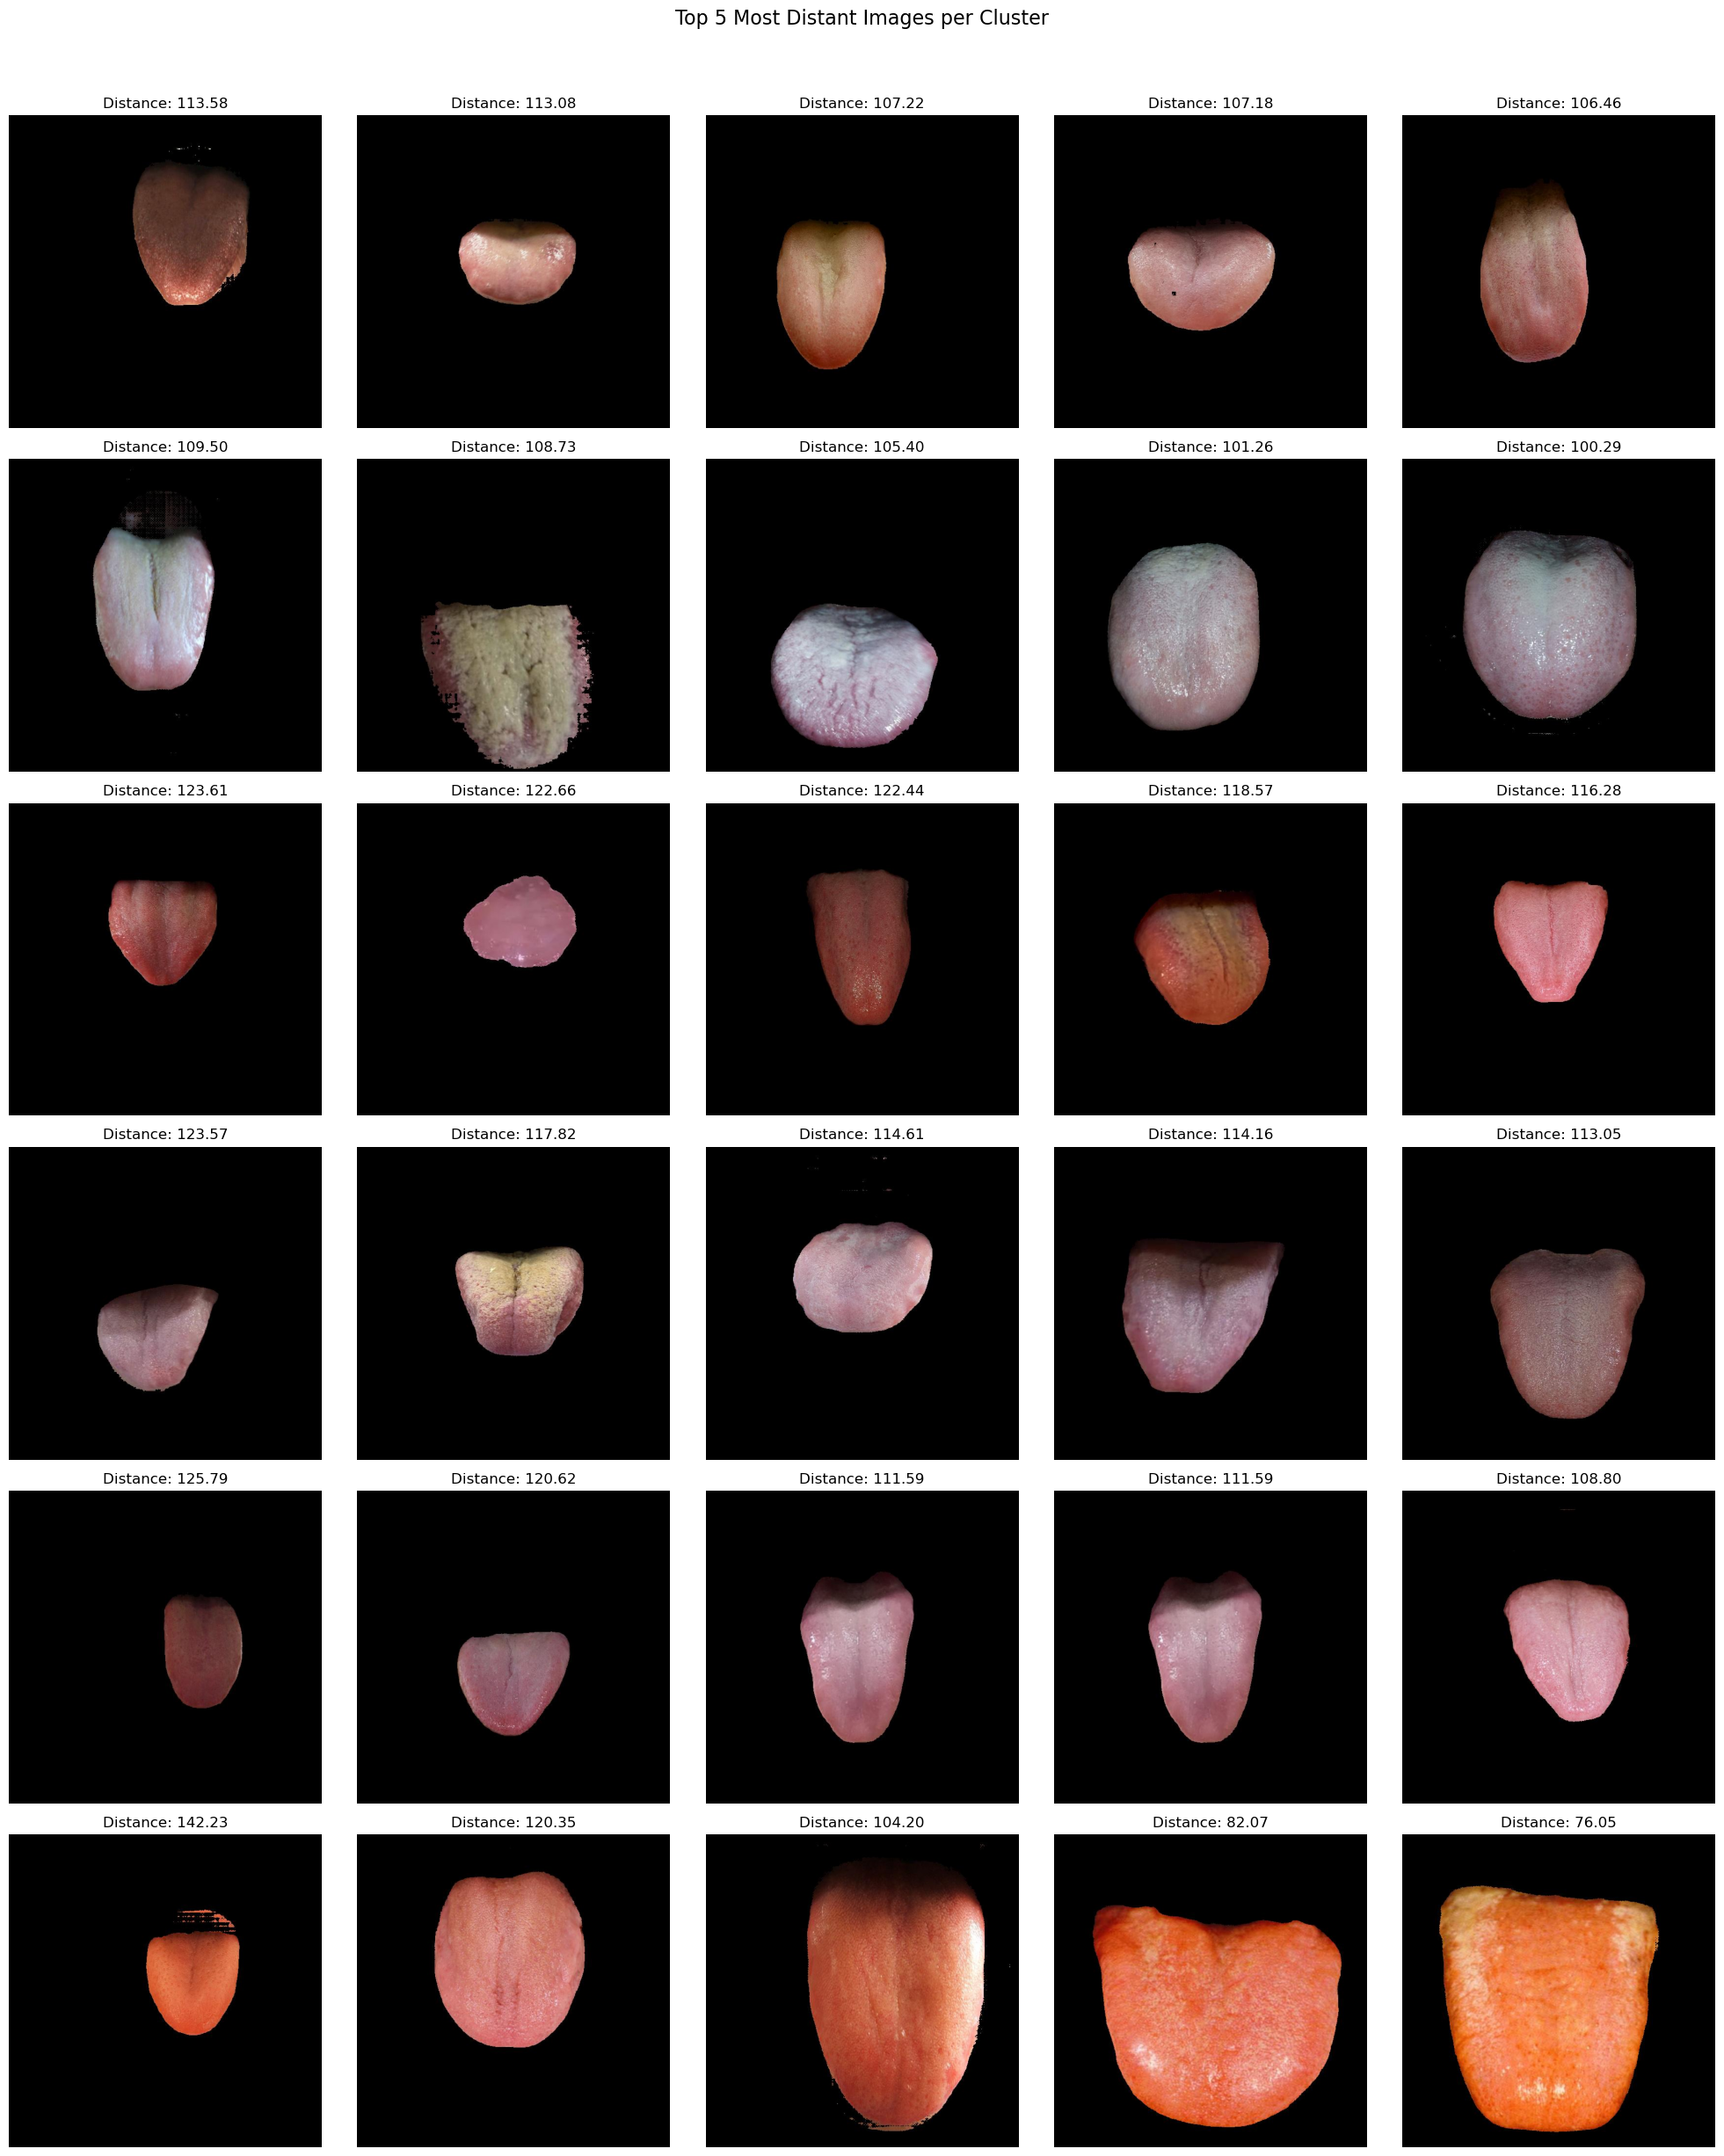

In [12]:
distances_df = pd.read_csv(f'cluster_distances_{num_clusters}.csv')

# Get unique clusters
clusters = distances_df['cluster'].unique()

# Create a figure with subplots for each cluster
fig, axes = plt.subplots(len(clusters), 5, figsize=(20, 4*len(clusters)))

# For each cluster
for cluster_idx, cluster in enumerate(clusters):
    # Get cluster-specific data
    cluster_data = distances_df[distances_df['cluster'] == cluster]
    
    # Get top 5 distant images for this cluster
    top_5_cluster = cluster_data.nlargest(5, 'centroid_distance')
    
    # Plot each image
    for img_idx, (_, row) in enumerate(top_5_cluster.iterrows()):
        img = plt.imread(f'clusters/clustered_images/' + row['cluster'] + '/' + row['image_name'])
        axes[cluster_idx, img_idx].imshow(img)
        axes[cluster_idx, img_idx].set_title(f"Distance: {row['centroid_distance']:.2f}")
        axes[cluster_idx, img_idx].axis('off')
    
plt.suptitle('Top 5 Most Distant Images per Cluster', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()